## Silverbox

Silverbox is the name of a nonlinear system identification benchmark, proposed in 2004. Data, baselines and more info can be found at http://nonlinearbenchmark.org/#Silverbox.

State-space formulation of Silverbox's dynamics:

$$\begin{align}
\mu \frac{d^2 x(t)}{dt^2} + \nu \frac{d x(t)}{dt} + \kappa(x(t)) x(t) =&\ u(t) + w(t) \\
\kappa(x(t)) =&\ \alpha + \beta x^2(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
\mu     =&\ \text{mass} \\
\nu     =&\ \text{viscous damping} \\
\kappa(x(t)) =&\ \text{nonlinear spring} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

### Steps to solve

I now take a series of steps to re-write this problem:

#### 1. Assume constant spring coefficient κ

$$ \mu \frac{d^2 x(t)}{dt^2} + \nu \frac{d x(t)}{dt} + κ x(t) = u(t) + w(t)$$

#### 2. Divide by leading coefficient

$$ \frac{d^2 x(t)}{dt^2} + \frac{\nu}{\mu} \frac{d x(t)}{dt} + \frac{κ}{\mu} x(t) = \frac{1}{\mu} u(t) + \frac{1}{\mu} w(t)$$

#### 3. Substitute standard variables

$$ \frac{d^2 x(t)}{dt^2} + 2\zeta \omega_0 \frac{d x(t)}{dt} + \omega_0^2 x(t) - \frac{u(t)}{\mu} = \frac{w(t)}{\mu}$$

where $$\begin{align} 
\zeta =&\ \frac{\nu}{2\sqrt{\mu \kappa}} \\ 
\omega_0 =&\ \sqrt{\frac{\kappa}{\mu}} \, .
\end{align}$$

#### 4. Apply Euler's method to obtain difference equation

-> Forward Euler:

$$\begin{align}
\frac{x(t+2h)-2x(t+h)+x(t)}{h^2} + 2\zeta \omega_0 \frac{x(t+h)-x(t)}{h} + \omega_0^2 x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu}
\end{align}$$
Set $h$ to sampling frequency and swap to index time-points:
$$\begin{align}
x_{t+2} + 2(\zeta \omega_0 - 1) x_{t+1} + (1 - 2 \zeta \omega_0 + \omega_0^2) x_{t} - \frac{u_t}{\mu} =&\ \frac{w_t}{\mu} 
\end{align}$$

-> Backward Euler:

$$\begin{align}
\frac{x(t)-2x(t-h)+x(t-2h)}{h^2} - 2\zeta \omega_0 \frac{x(t)-x(t-h)}{h} - \omega_0^2 x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu} 
\end{align}$$
Set $h$ to sampling frequency and swap to index time-points:
$$\begin{align}
(1 + 2 \zeta \omega_0 + \omega_0^2)x_t - 2(1 + \zeta \omega_0)x_{t-1} - x_{t-2} - \frac{u_t}{\mu} =&\ \frac{w_t}{\mu} \\
x_t - \frac{2(1 + \zeta \omega_0)}{(1 + 2\zeta \omega_0 + \omega_0^2)}x_{t-1} - \frac{1}{(1 + 2\zeta \omega_0 + \omega_0^2)}x_{t-2} - \frac{u_t}{\mu(1 + 2\zeta \omega_0 + \omega_0^2)} =&\ \frac{w_t}{\mu(1 + 2\zeta \omega_0 + \omega_0^2)}
\end{align}$$
    
Change to shorthand notation:

$$x_t - \theta_1 x_{t-1} - \theta_2 x_{t-2} - \eta u_t = \eta w_t$$

where 
$$\begin{align} 
\theta_1 =&\ \frac{2(1 + \zeta \omega_0)}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\theta_2 =&\ \frac{1}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\eta =&\ \frac{1}{\mu(1 + 2 \zeta \omega_0 + \omega_0^2)}
\end{align}$$

Given three equations and three unknowns, I can recover $\zeta$, $\omega_0$ and $\mu$ from $\theta_1$, $\theta_2$, and $\eta$.

#### 5. Convert to multivariate first-order difference form

Stick to backward Euler (matches AR structure)
- Backward Euler:

    $$z_t = A(\theta) z_{t-1} + c\eta u_t + c\eta w_t$$

    where $z_t = [x_t\ \ x_{t-1}]$, $A(\theta) = [\theta_1 \ \ \theta_2; 1\ \ 0]$, $c = [1\ \ 0]$.

#### 6. Convert to Gaussian probability

- Backward Euler:

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, cc^{\top} \eta \tau)$$

for $w_t \sim \mathcal{N}(0, \tau)$.

#### 7. Observation likelihood

$$y_t \sim \mathcal{N}(c^{\top} z_t, σ)$$

where $e_t \sim \mathcal{N}(0, \sigma)$.

I will first study a situation with known measurement noise (so $\sigma$ is fixed). That means I need priors for $\theta$, $\eta$, and $\tau$. The variables are all strictly positive, which means they can be modeled by log-normal and gamma distributions:

$$\begin{align}
\log(\theta) \sim&\ \mathcal{N}(m_\theta, W_\theta) \\
\log(\eta) \sim&\ \mathcal{N}(m_\eta, W_\eta) \\
\tau \sim&\ Γ(a_\tau, b_\tau) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [3]:
using Plots

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
Plots.savefig(p1, "viz/output_signal.png")

In [5]:
p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
Plots.savefig(p2, "viz/input_signal.png")

## Implementation

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **



I will use the Nonlinear node to cope with a log-normal distribution.

In [7]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV lθ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:W_θ, dims=(2,2)))
@RV lη ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
# @RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

# Nonlinear function
g(x) = exp.(x)
g_inv(x) = log.(x)

# Nonlinear node
# @RV θ ~ Nonlinear{Unscented}(log_θ; g=g, g_inv=g_inv, dims=(2,)) # DomainError on log as g_inv
@RV θ ~ Nonlinear{Unscented}(lθ; g=g, dims=(2,))
@RV η ~ Nonlinear{Unscented}(lη; g=g, dims=(1,))

# Observation selection variable
c = [1, 0]

# Placeholder for control
# @RV u_t ~ GaussianMeanPrecision(placeholder(:m_u), 1e12, id=:u_t)

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:W_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), τ, id=:x_t)

# Selecting the first element of current state variable
@RV cx_t = dot(c, x_t)
cx_t.id = :cx_t

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(cx_t, 10., id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2957384904594016050 -->
 
 2957384904594016050 
 
 clamp_1 
 
<!-- 3865820462277412277 -->
 
 3865820462277412277 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5629181357262804425 -->
 
 5629181357262804425 
 
 placeholder_m_θ 
 
<!-- 3865820462277412277--5629181357262804425 -->
 
 3865820462277412277--5629181357262804425 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 3170302361401499587 -->
 
 3170302361401499587 
 
 placeholder_W_θ 
 
<!-- 3865820462277412277--3170302361401499587 -->
 
 3865820462277412277--3170302361401499587 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 9541055651952785096 -->
 
 9541055651952785096 
 
 placeholder_m_z 
 
<!-- 2783292648591588550 -->
 
 2783292648591588550 
 
 placeholder_u_t 
 
<!-- 15136264126938258992 -->
 
 15136264126938258992 
 
 clamp_2 
 
<!-- 8530737782736284978 -->
 
 8530737782736284978 
 
 dot 
 dotproduct_1 
 
<!-- 8530737782736284978--2957384904594016050 -->
 
 8530737782736284978--2957384904594016050 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 1235807737860245700 -->
 
 1235807737860245700 
 
 ARC 
 x_t 
 
<!-- 8530737782736284978--1235807737860245700 -->
 
 8530737782736284978--1235807737860245700 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 5563452801310486377 -->
 
 5563452801310486377 
 
 placeholder_w_η 
 
<!-- 10260155000089517732 -->
 
 10260155000089517732 
 
 placeholder_W_z 
 
<!-- 16717701225382838544 -->
 
 16717701225382838544 
 
 𝒩 
 z_t 
 
<!-- 16717701225382838544--9541055651952785096 -->
 
 16717701225382838544--9541055651952785096 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16717701225382838544--10260155000089517732 -->
 
 16717701225382838544--10260155000089517732 
 
 W_z 
 1 out 
 3 w 
 
<!-- 11692238360919883705 -->
 
 11692238360919883705 
 
 placeholder_a_τ 
 
<!-- 16898809218195995241 -->
 
 16898809218195995241 
 
 Nonlinear{Unscented} 
 nonlinear_2 
 
<!-- 16848090746098480935 -->
 
 16848090746098480935 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16898809218195995241--16848090746098480935 -->
 
 16898809218195995241--16848090746098480935 
 
 lη 
 1 out 
 2 in1 
 
<!-- 15667652429171090530 -->
 
 15667652429171090530 
 
 Nonlinear{Unscented} 
 nonlinear_1 
 
<!-- 15667652429171090530--3865820462277412277 -->
 
 15667652429171090530--3865820462277412277 
 
 lθ 
 1 out 
 2 in1 
 
<!-- 651478096911975762 -->
 
 651478096911975762 
 
 placeholder_b_τ 
 
<!-- 16848090746098480935--5563452801310486377 -->
 
 16848090746098480935--5563452801310486377 
 
 w_η 
 1 out 
 3 w 
 
<!-- 12992219357385845601 -->
 
 12992219357385845601 
 
 placeholder_m_η 
 
<!-- 16848090746098480935--12992219357385845601 -->
 
 16848090746098480935--12992219357385845601 
 
 m_η 
 1 out 
 2 m 
 
<!-- 7877740386583091457 -->
 
 7877740386583091457 
 
 Gam 
 gamma_1 
 
<!-- 7877740386583091457--11692238360919883705 -->
 
 7877740386583091457--11692238360919883705 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 7877740386583091457--651478096911975762 -->
 
 7877740386583091457--651478096911975762 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 2453951463796545154 -->
 
 2453951463796545154 
 
 placeholder_y_t 
 
<!-- 7291203129470502240 -->
 
 7291203129470502240 
 
 𝒩 
 y_t 
 
<!-- 2453951463796545154--7291203129470502240 -->
 
 2453951463796545154--7291203129470502240 
 
 y_t 
 1 out 
 1 out 
 
<!-- 7291203129470502240--15136264126938258992 -->
 
 7291203129470502240--15136264126938258992 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 7291203129470502240--8530737782736284978 -->
 
 7291203129470502240--8530737782736284978 
 
 cx_t 
 1 out 
 2 m 
 
<!-- 1235807737860245700--2783292648591588550 -->
 
 1235807737860245700--2783292648591588550 
 
 u_t 
 1 out 
 5 u 
 
<!-- 1235807737860245700--16717701225382838544 -->
 
 1235807737860245700--16717701225382838544 
 
 z_t 
 1 out 
 2 x 
 
<!-- 1235807737860245700--16898809218195995241 -->
 
 12358077378602457

In [8]:
# Infer an algorithm
# q = PosteriorFactorization(z_t, x_t, u_t, θ, lθ, η, lη, τ, ids=[:z, :x, :u, :θ, :lθ, :η, :lη, :τ])
q = PosteriorFactorization(z_t, x_t, θ, lθ, η, lη, τ, ids=[:z, :x, :θ, :lθ, :η, :lη, :τ])
# q = PosteriorFactorization(z_t, x_t, θ, lθ, η, lη, τ, γ, ids=[:z, :x, :θ, :lθ, :η, :lη, :τ, :γ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

In [9]:
# Looking at only the first few timepoints
T = 10
# T = size(df, 1);

# Inference parameters
num_iterations = 5

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
# params_z = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.01 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), 1. *ones(1,T+1))
params_τ = (0.1*ones(1,T+1), 0.01*ones(1,T+1))
# params_γ = (0.1*ones(1,T+1), 0.01*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
#     marginals[:u_t] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=input[t], w=1e12)
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,t], b=params_τ[2][1,t])
#     marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :m_θ => params_θ[1][:,t],
                :m_η => params_η[1][1,t],
                :W_z => params_x[2][:,:,t],
                :W_θ => params_θ[2][:,:,t],
                :w_η => params_η[2][1,t],
                :a_τ => params_τ[1][1,t],
                :b_τ => params_τ[2][1,t])
#                 :a_γ => params_γ[1][1,t],
#                 :b_γ => params_γ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
#         stepz!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepτ!(data, marginals)
#         stepγ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
#     params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
#     params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_τ[1][1,t+1] = marginals[:τ].params[:a]
    params_τ[2][1,t+1] = marginals[:τ].params[:b]
#     params_γ[1][1,t+1] = marginals[:γ].params[:a]
#     params_γ[2][1,t+1] = marginals[:γ].params[:b]

end

At time  20%|████████▋                                  |  ETA: 0:00:49

ErrorException: PosDefException: Matrix is not positive-definite, even after regularization. Array{Float64,2}:
[195112.1359902545 4.969419806502103e7; 4.969419806502103e7 1.2655571641677246e10]

In [10]:
marginals

Dict{Any,Any} with 9 entries:
  :γ    => Gam(a=0.10, b=1.00e-02)…
  :lη   => 𝒩(xi=1.05e+11, w=3.85e+10)…
  :cx_t => 𝒩(xi=-0.13, w=10.29)…
  :τ    => Gam(a=3.60, b=12.23)…
  :x_t  => 𝒩(xi=[-0.13, -1.14e+06], w=[[10.29, 0.00][0.00, 1.00e+08]])…
  :lθ   => 𝒩(xi=[-0.02, -1.86e-04], w=[[0.10, -2.38e-04][-2.38e-04, 1.51e-04]])…
  :z_t  => 𝒩(m=[-0.01, -9.04e-03], w=[[10.29, 0.00][0.00, 1.00e+08]])…
  :θ    => 𝒩(m=[0.85, 41.73], w=[[0.05, -1.93e-04][-1.93e-04, 6.88e-06]])…
  :η    => 𝒩(m=15.15, w=1.67e+08)…

In [11]:
println(unsafeMean(marginals[:x_t]))
println(unsafeMean(marginals[:z_t]))
println(unsafeMean(marginals[:θ]))
println(unsafeMean(marginals[:η]))
println(unsafeMean(marginals[:τ]))

[-0.013080047191992392, -0.011400757424893925]
[-0.011400757424893923, -0.009043223988344977]
[0.8548644450680233, 41.73272126426748]
15.154316892848163
0.29445668833603467


In [12]:
println(unsafePrecision(marginals[:x_t]))
println(unsafePrecision(marginals[:z_t]))
println(unsafePrecision(marginals[:θ]))
println(unsafePrecision(marginals[:η]))
println(unsafeVar(marginals[:τ]))

[10.294456688337036 0.0; 0.0 1.0e8]
[10.29445620187196 0.0; 0.0 1.0e8]
[0.04910853756178353 -0.00019280879263396564; -0.00019280879263396564 6.876804109542028e-6]
1.6747707964478466e8
0.024084650362729075


In [13]:
mθ = unsafeMean(marginals[:θ])
Vθ = unsafeCov(marginals[:θ])

2×2 Array{Float64,2}:
  22.8819     641.553
 641.553   163404.0  

In [14]:
mη = unsafeMean(marginals[:η])
vη = unsafeCov(marginals[:η])

5.970966308470263e-9

In [15]:
vu = 0.
mu = input[T]

0.006526

In [16]:
mz = unsafeMean(marginals[:z_t])
Vz = unsafeCov(marginals[:z_t])

2×2 Array{Float64,2}:
  0.0971397  -0.0   
 -0.0         1.0e-8

In [17]:
mx = unsafeMean(marginals[:x_t])
mx*mx'

2×2 Array{Float64,2}:
 0.000171088  0.000149122
 0.000149122  0.000129977

In [18]:
Wx = unsafePrecision(marginals[:x_t])
Vx = unsafeCov(marginals[:x_t])

2×2 Array{Float64,2}:
  0.0971397  -0.0   
 -0.0         1.0e-8

In [19]:
S = [0. 0.;1. 0.]
c = [1., 0.]

2-element Array{Float64,1}:
 1.0
 0.0

In [20]:
mγ = unsafeMean(marginals[:τ])

0.29445668833603467

In [21]:
mγ*mu^2

1.2540520495576358e-5

In [22]:
mW = wMatrix(mγ, 2)

# Expectation of AR coefficient matrix
mA = S + c*mθ'

# Parameters of outgoing message
w = mγ*(mu^2 + vu)
xi = (mu*c')*mW*(mx - mA*mz)

0.0007188112607375413

In [23]:
Vx[1,1] + mx[1]*mx[1] + mx'*Vθ*mx + mθ'*(Vx + mx*mx')*mθ -2*mx[1]*(mθ'*mx + mη*mu) + 2*mθ'*mx*mη*mu + (mu^2+vu)*(mη^2+vη)

21.74281820385054

In [24]:
mx_7 = params_x[1][:,7]
Vx_7 = params_x[2][:,:,7]
Vx_7 + mx_7*mx_7'

2×2 Array{Float64,2}:
 10.2863      3.58523e-5
  3.58523e-5  1.0e8     

In [25]:
params_x[1][:,5:10]

2×6 Array{Float64,2}:
 0.0229373  -0.00396455  -0.00904322  -0.0114008   0.0  0.0
 0.0110234   0.0229373   -0.00396455  -0.00904322  0.0  0.0

In [26]:
params_θ[2][:,:,8]

2×2 Array{Float64,2}:
  0.0491085    -0.000192809
 -0.000192809   6.8768e-6  

In [27]:
mθ = unsafeMean(marginals[:θ])
Vθ = unsafeCov(marginals[:θ])
Wθ = unsafePrecision(marginals[:θ])
# marginals[:θ]

2×2 Array{Float64,2}:
  0.0491085    -0.000192809
 -0.000192809   6.8768e-6  

In [28]:
m_x = unsafeMean(marginals[:x_t])
V_x = unsafeCov(marginals[:x_t])

2×2 Array{Float64,2}:
  0.0971397  -0.0   
 -0.0         1.0e-8

In [29]:
marginals[:z_t]

𝒩(m=[-0.01, -9.04e-03], w=[[10.29, 0.00][0.00, 1.00e+08]])


In [30]:
output[1:10]

10-element Array{Float64,1}:
  0.0093978
  0.012971 
  0.010825 
  0.004072 
 -0.0039647
 -0.0092378
 -0.0093763
 -0.0047789
  0.0020409
  0.0079169

In [31]:
estimated_coeffs = params_θ[1][:,2:end]
estimated_states = params_x[1][1,2:end]

10-element Array{Float64,1}:
  0.01930778293052664 
  0.03277263419331982 
  0.011023360294116219
  0.0229372729933307  
 -0.003964545066760749
 -0.009043223988344977
 -0.011400757424893923
  0.0                 
  0.0                 
  0.0                 

In [32]:
begin

function initlη()

messages = Array{Message}(undef, 4)


return messages

end

function steplη!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:m_η]), ProbabilityDistribution(Univariate, PointMass, m=data[:w_η]))
messages[2] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])
messages[3] = ruleVariationalARCIn3PPPNPP(marginals[:x_t], marginals[:z_t], marginals[:θ], nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])
messages[4] = ruleSPNonlinearUTIn1GG(g, messages[3], messages[1])

marginals[:lη] = messages[1].dist * messages[4].dist
marginals[:η] = messages[2].dist * messages[3].dist

return marginals

end

function stepτ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_τ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_τ]))
messages[2] = ruleVariationalARCIn5PPPPPN(marginals[:x_t], marginals[:z_t], marginals[:θ], marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), nothing)

marginals[:τ] = messages[1].dist * messages[2].dist

return marginals

end

function initlθ()

messages = Array{Message}(undef, 4)


return messages

end

function steplθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:W_θ]))
messages[2] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])
messages[3] = ruleVariationalARCIn2PPNPPP(marginals[:x_t], marginals[:z_t], nothing, marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])
messages[4] = ruleSPNonlinearUTIn1GG(g, messages[3], messages[1])

marginals[:lθ] = messages[1].dist * messages[4].dist
marginals[:θ] = messages[2].dist * messages[3].dist

return marginals

end

function stepz!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_z]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:W_z]))
messages[2] = ruleVariationalARCIn1PNPPPP(marginals[:x_t], nothing, marginals[:θ], marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])

marginals[:z_t] = messages[1].dist * messages[2].dist

return marginals

end

function initθ()

messages = Array{Message}(undef, 4)

messages[1] = Message(vague(GaussianMeanPrecision, (2,)))

return messages

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:W_θ]))
messages[2] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])
messages[3] = ruleVariationalARCIn2PPNPPP(marginals[:x_t], marginals[:z_t], nothing, marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])
messages[4] = ruleSPNonlinearUTIn1GG(g, messages[3], messages[1])

marginals[:lθ] = messages[1].dist * messages[4].dist
marginals[:θ] = messages[2].dist * messages[3].dist

return marginals

end

function initη()

messages = Array{Message}(undef, 4)

messages[1] = Message(vague(GaussianMeanPrecision, (1,)))

return messages

end

function stepη!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:m_η]), ProbabilityDistribution(Univariate, PointMass, m=data[:w_η]))
messages[2] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])
messages[3] = ruleVariationalARCIn3PPPNPP(marginals[:x_t], marginals[:z_t], marginals[:θ], nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])
messages[4] = ruleSPNonlinearUTIn1GG(g, messages[3], messages[1])

marginals[:lη] = messages[1].dist * messages[4].dist
marginals[:η] = messages[2].dist * messages[3].dist

return marginals

end

function stepx!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARCOutNPPPPP(nothing, marginals[:z_t], marginals[:θ], marginals[:η], ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), nothing, ProbabilityDistribution(Univariate, PointMass, m=10.0))
messages[3] = ruleSPDotProductIn1GNP(messages[2], nothing, Message(Multivariate, PointMass, m=[1, 0]))
messages[4] = ruleSPDotProductOutNGP(nothing, messages[1], Message(Multivariate, PointMass, m=[1, 0]))

marginals[:cx_t] = messages[4].dist * messages[2].dist
marginals[:x_t] = messages[1].dist * messages[3].dist

return marginals

end

end # block

stepx! (generic function with 3 methods)

### Visualize results

In [33]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
Plots.savefig(p1, "viz/estimated_states01.png")

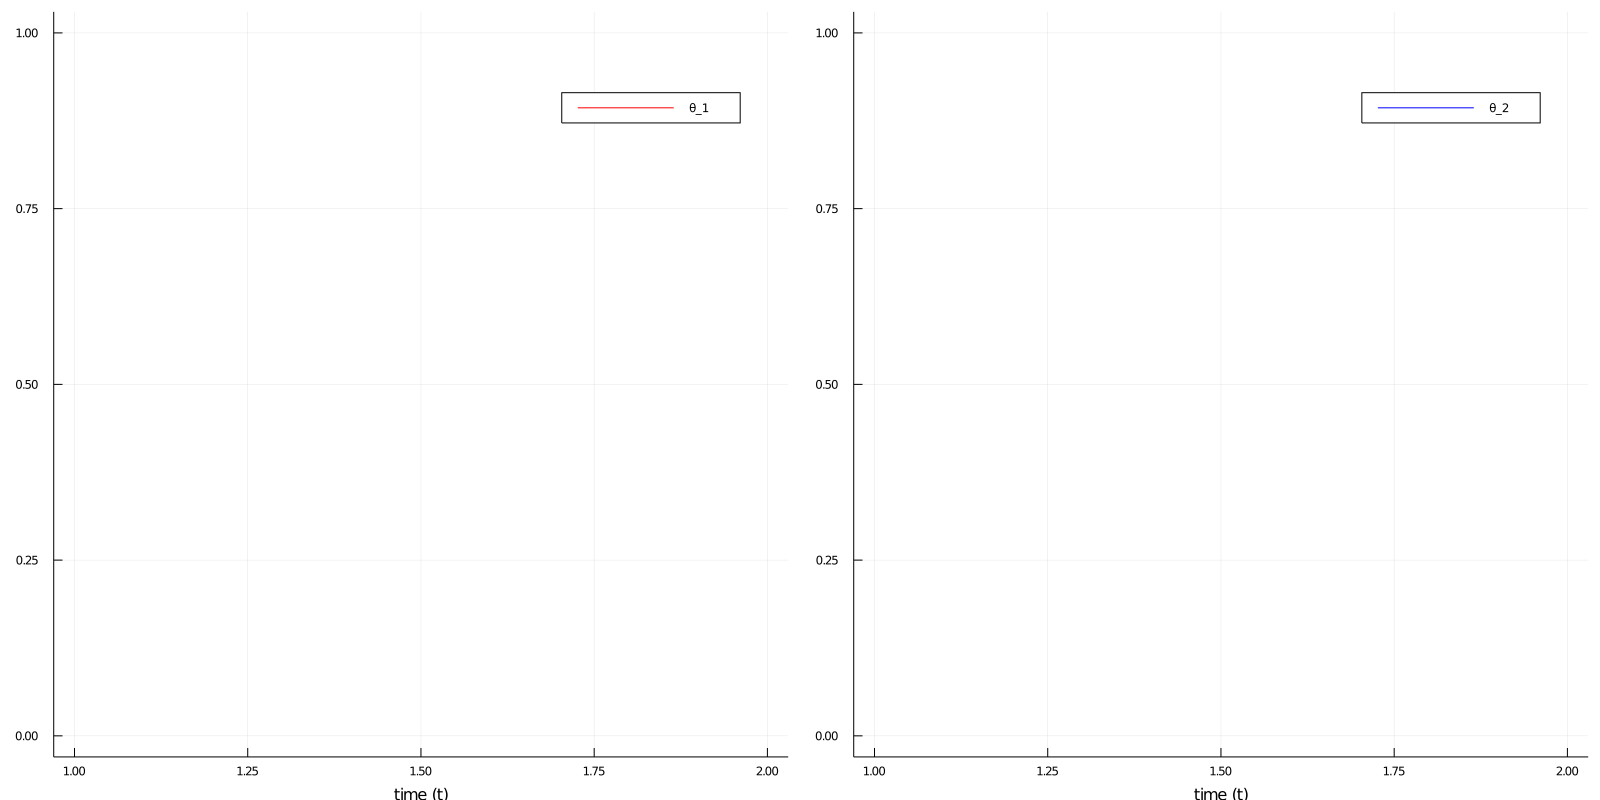

In [34]:
p2a = Plots.plot(1:n:T, estimated_coeffs[1,1:n:T], color="red", label="θ_1", xlabel="time (t)")
p2b = Plots.plot(1:n:T, estimated_coeffs[2,1:n:T], color="blue", label="θ_2", xlabel="time (t)")
plot(p2a, p2b, size=(1600,800))
# Plots.savefig(p1, "viz/estimated_coeffs1.png")